# Integrated gradients for text classification on imdb dataset

In this example, we apply the integrated gradients method to a sentiment analysis model trained on the imdb dataset. A description of the method can be found [here](../doc/source/methods/IntegratedGradients.ipynb). Integrated gradients was originally proposed in [here](https://arxiv.org/abs/1703.01365).

The imdb data set contains 50K movie reviews labelled as positive or negative. 
We train a convolutional neural network classifier with a single 1-d convolutional layer followed by a fully connected layer. The reviews in the dataset are trunkated at 100 words and each word is reppresented by 50-dimentional word embedding vector. 

We calculate attributions for the elements of the embedding layer using the alibi implementation of the integrated gradients method.

In [2]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import numpy as np
import os
import pandas as pd
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout 
from tensorflow.keras.utils import to_categorical
from alibi.explainers import IntegratedGradients
import matplotlib.pyplot as plt
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly())

TF version:  1.15.0
Eager execution enabled:  True


In [116]:
def decode_sentence(x):
    return " ".join( [reverse_index.get(i - 3, '#') for i in x] )

def visualize_attributions(sentences, test_labels, attrs, i=1):
    sentence = decode_sentence(sentences[i])
    words = sentence.split(' ')
    attrs = attrs[i].tolist()
    df = pd.DataFrame()
    df['words'] = words
    df['attributions'] = attrs
    df.set_index('words', inplace=True)
    df = df.iloc[::-1]
    
    print('True label', test_labels[i])
    df.plot(kind='barh', figsize=(8, 16))

## Load data

Loading the imdb dataset. 

In [117]:
max_features = 10000
maxlen = 100

In [118]:
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
test_labels = y_test.copy()
train_labels = y_train.copy()
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

index = imdb.get_word_index()
reverse_index = dict([(value, key) for (key, value) in index.items()]) 

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 100)
x_test shape: (25000, 100)


A sample review from the test set. Note that unknown words are replaced with '#'

In [114]:
print(decode_sentence(x_test[-1])) 

up way short big john is big but he isn't convincing with the bad part of his # bug eyed jack # is a hoot as always and bo hopkins has been playing this same part for decades ned beatty also does his part in a small role but there is no story it # more like an episode of in the heat of the night than a feature film # with easily predictable sentiment perhaps the most glaring problem with this movie is charlie daniels singing the theme you know the one it was made famous by jimmy dean


## Train Model

The model includes 1 convolutional layers and it reaches a test accuracy of 0.85. If `save_model = True`, a local folder `../model_imdb` will be created and the trained model will be saved in that folder. If the model was previously saved, it can be loaded by setting `load_model = True`.

In [93]:
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250

In [94]:
load_model = False
save_model = True

In [127]:
filepath = './model_imdb/'  # change to directory where model is downloaded
if load_model:
    model = tf.keras.models.load_model(os.path.join(filepath, 'model.h5'))
else:
    print('Build model...')
    
    inputs = Input(shape=(100,), dtype='int32')
    embedded_sequences = Embedding(max_features,
                                   embedding_dims)(inputs)
    out = Conv1D(filters, 
                 kernel_size, 
                 padding='valid', 
                 activation='relu', 
                 strides=1)(embedded_sequences)
    out = Dropout(0.4)(out)
    out = GlobalMaxPooling1D()(out)
    out = Dense(hidden_dims, 
                activation='relu')(out)
    out = Dropout(0.4)(out)
    outputs = Dense(2, activation='softmax')(out)
        
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    print('Train...')
    model.fit(x_train, y_train,
              batch_size=256,
              epochs=3,
              validation_data=(x_test, y_test))
    if save_model:  
        if not os.path.exists(filepath):
            os.makedirs(filepath)
        model.save(os.path.join(filepath, 'model.h5')) 

Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 2s 90us/sample - loss: 0.5885 - acc: 0.6696 - val_loss: 0.4162 - val_acc: 0.8228
Epoch 2/3
25000/25000 [==============================] - 2s 67us/sample - loss: 0.3179 - acc: 0.8652 - val_loss: 0.3621 - val_acc: 0.8446
Epoch 3/3
25000/25000 [==============================] - 2s 68us/sample - loss: 0.2107 - acc: 0.9202 - val_loss: 0.3387 - val_acc: 0.8514


## Calculate integrated Gradients

The integrated gradients are calculate with respect to the embedding layer for 10 samples from the test set. Since the model uses a word to vector embedding with vector's dimensionality of 50 and sequence lenght of 100 words, the dimensionality of the attributions is (10, 100, 50). 
 
The default baselines are used in this example, which is internally defined as a sequence of zeros. In this case, this corresponds to a sequence of padding characters. The path integral is defined as a straight like from the baseline to the input image. The path is approximated by choosing 50 discrete steps according to the Gauss-Legendre method.

In [96]:
n_steps = 50
method = "gausslegendre"
return_convergence_delta = True
return_predictions = False
internal_batch_size = 100
nb_samples = 10
ig  = IntegratedGradients(model, layer=model.layers[1],
                          n_steps=n_steps, 
                          method=method)

In [97]:
x_test_red = x_test[:nb_samples]
test_labels_red = test_labels[:nb_samples]
explanation = ig.explain(x_test_red, 
                         baselines=None, 
                         target=test_labels_red, 
                         internal_batch_size=internal_batch_size, 
                         return_convergence_delta=return_convergence_delta, 
                         return_predictions=return_predictions)

In [99]:
attrs = explanation.data['attributions']
print('Attributions shape:', attrs.shape)

Attributions shape: (10, 100, 50)


### Sum attributions

In order to obtain a single attribution value for each word, we sum all the attribution values for the 50 element of the word's vector representation.

In [100]:
attrs = attrs.sum(axis=2)
print('Attributions shape:', attrs.shape)

Attributions shape: (10, 100)


## Visualize attributions

In [90]:
i = 1

True label 1


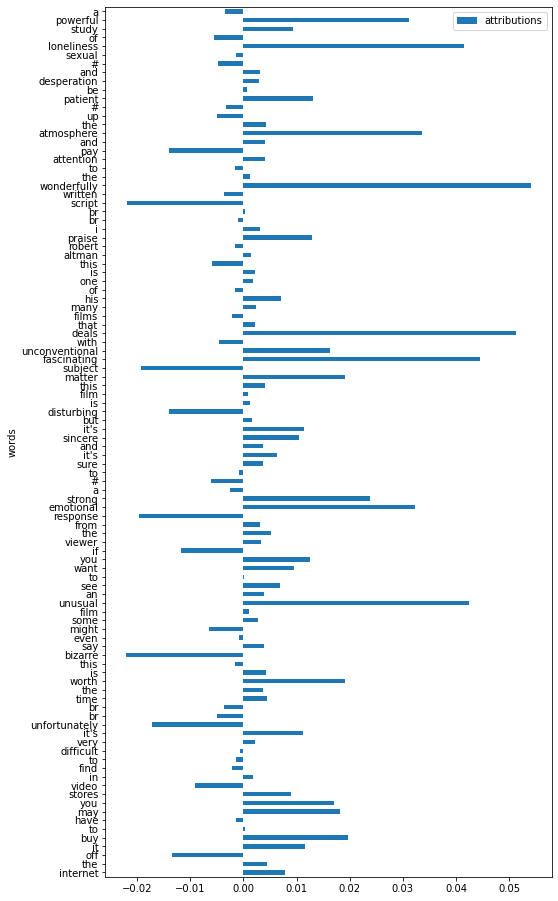

In [103]:
visualize_attributions(x_test_red, test_labels_red, attrs, i=i)